In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


In [4]:

train_transaction_path = '/kaggle/input/competitions/ieee-fraud-detection/train_transaction.csv'
train_identity_path = '/kaggle/input/competitions/ieee-fraud-detection/train_identity.csv'
test_transaction_path = '/kaggle/input/competitions/ieee-fraud-detection/test_transaction.csv'
test_identity_path = '/kaggle/input/competitions/ieee-fraud-detection/test_identity.csv'
 

In [5]:
# load trainig files
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)

# load test files 
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)

print(f" train_transaction: {train_transaction.shape}")
print(f" train_identity: {train_identity.shape}")
print(f" test_transaction: {test_transaction.shape}")
print(f" test_identity: {test_identity.shape}")

 train_transaction: (590540, 394)
 train_identity: (144233, 41)
 test_transaction: (506691, 393)
 test_identity: (141907, 41)


In [6]:
# to reduce the memory 
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
            else:
                df[col] = df[col].astype(np.float32)
    return df

In [7]:
train_transaction = pd.read_csv(train_transaction_path)
train_transaction = reduce_mem_usage(train_transaction)

# merge DataFrames

In [8]:
# Merge Transaction and Identity Tables
# Merge training data
train = train_transaction.merge(train_identity, on='TransactionID', how='left')

# Merge test data
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

print(f" Training data shape: {train.shape}")
print(f" Test data shape: {test.shape}")


 Training data shape: (590540, 434)
 Test data shape: (506691, 433)


In [9]:
#standardize 
# colums name
print("Training columns:", [col for col in train.columns if 'id_' in col][:5])
print("Test columns:", [col for col in test.columns if 'id-' in col][:5])


Training columns: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05']
Test columns: ['id-01', 'id-02', 'id-03', 'id-04', 'id-05']


In [10]:
# Standardize names in test data
id_columns = [col for col in test.columns if 'id-' in col]
for col in id_columns:
    new_col = col.replace('id-', 'id_')
    test.rename(columns={col: new_col}, inplace=True)

# Overview of the data

In [11]:
train.shape

(590540, 434)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(376), float64(23), int16(1), int64(2), int8(1), object(31)
memory usage: 1.1+ GB


In [13]:
# Save TransactionID for submission later
test_ids = test['TransactionID'].copy()

# Drop transaction IDs (not useful for training)
train = train.drop('TransactionID', axis=1)
test = test.drop('TransactionID', axis=1)

print(f"\n Final columns count: {train.shape[1]} columns")


 Final columns count: 433 columns


In [14]:
# : Overview of the Data
display(train.head())

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [15]:
# Data types information
print(train.dtypes.value_counts())

float32    376
object      31
float64     23
int8         1
int64        1
int16        1
Name: count, dtype: int64


In [16]:
# Numeric and categorical columns
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

In [17]:
print(f"\n Number of numeric columns: {len(numeric_cols)}")
print(f" Number of categorical columns: {len(categorical_cols)}")
print(f"\nExamples of categorical columns: {categorical_cols[:10]}")


 Number of numeric columns: 402
 Number of categorical columns: 31

Examples of categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5']


# Class Distribution 

**to detect imbalance data**

In [18]:
fraud_counts = train['isFraud'].value_counts()

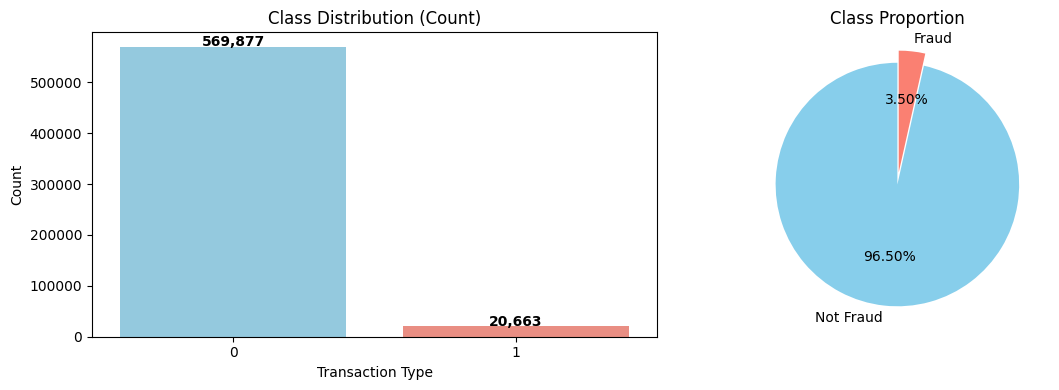

In [19]:
# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='isFraud', data=train, palette=['skyblue', 'salmon'])
plt.title('Class Distribution (Count)')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
for i, v in enumerate(fraud_counts):
    plt.text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], 
        autopct='%1.2f%%', colors=['skyblue', 'salmon'],
        startangle=90, explode=[0, 0.1])
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

In [20]:
# Step 6: Target Variable Analysis (isFraud)
# Class distribution
fraud_counts = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

print(f"   Not Fraud (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"   Fraud (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")

   Not Fraud (0): 569,877 (96.50%)
   Fraud (1): 20,663 (3.50%)


# Missing Values Analysis

In [21]:
# Calculate missing values percentage
missing_train = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
missing_test = (test.isnull().sum() / len(test) * 100).sort_values(ascending=False)

In [22]:
missing_train
missing_test

id_24    99.064519
id_25    99.005508
id_26    99.003929
id_08    99.001561
id_07    99.001561
           ...    
V109      0.000000
V110      0.000000
V111      0.000000
V112      0.000000
V113      0.000000
Length: 432, dtype: float64

In [23]:
# Display columns with missing values (>50%)
high_missing = missing_train[missing_train > 50]
print(high_missing.head(15))

id_24    99.196159
id_25    99.130965
id_08    99.127070
id_07    99.127070
id_21    99.126393
id_26    99.125715
id_22    99.124699
id_27    99.124699
id_23    99.124699
dist2    93.628374
D7       93.409930
id_18    92.360721
D13      89.509263
D14      89.469469
D12      89.041047
dtype: float64


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns 

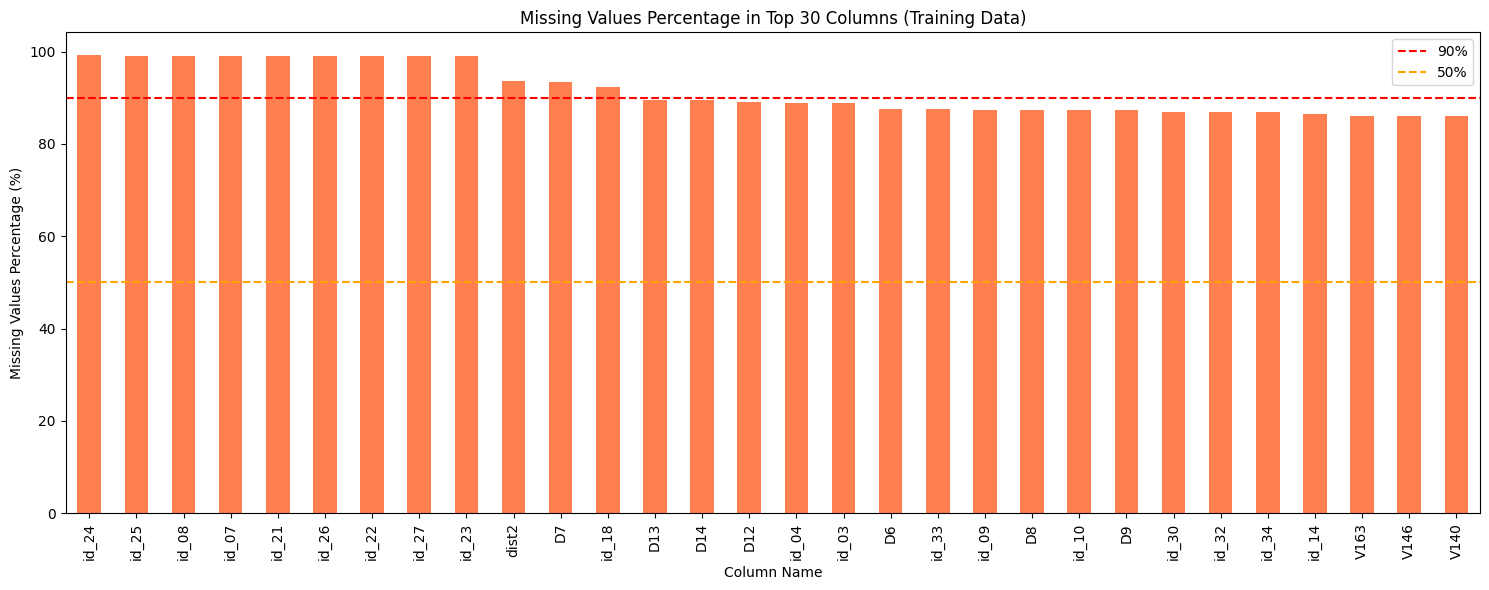

In [25]:
# Visualization of missing values
plt.figure(figsize=(15, 6))
missing_train.head(30).plot(kind='bar', color='coral')
plt.title('Missing Values Percentage in Top 30 Columns (Training Data)')
plt.ylabel('Missing Values Percentage (%)')
plt.xlabel('Column Name')
plt.xticks(rotation=90)
plt.axhline(y=90, color='r', linestyle='--', label='90%')
plt.axhline(y=50, color='orange', linestyle='--', label='50%')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
print(f"\n Number of columns with >90% missing: {(missing_train > 90).sum()}")
print(f"Number of columns with >50% missing: {(missing_train > 50).sum()}")


 Number of columns with >90% missing: 12
Number of columns with >50% missing: 214


#  Key Features Analysis

In [27]:
# 8.1: TransactionDT (Time)
print(f"   Min value: {train['TransactionDT'].min():,}")
print(f"   Max value: {train['TransactionDT'].max():,}")
print(f"   Range: {(train['TransactionDT'].max() - train['TransactionDT'].min()) / 86400:.1f} days")

   Min value: 86,400
   Max value: 15,811,131
   Range: 182.0 days


In [28]:
# Convert seconds to days and hours
train['TransactionDay'] = train['TransactionDT'] / (24*60*60)
train['DayOfWeek'] = (train['TransactionDay'] % 7).astype(int)
train['Hour'] = (train['TransactionDT'] / 3600) % 24

In [29]:

print(train['TransactionAmt'].describe())

count    590540.000000
mean        135.027161
std         239.162689
min           0.251000
25%          43.320999
50%          68.769001
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64


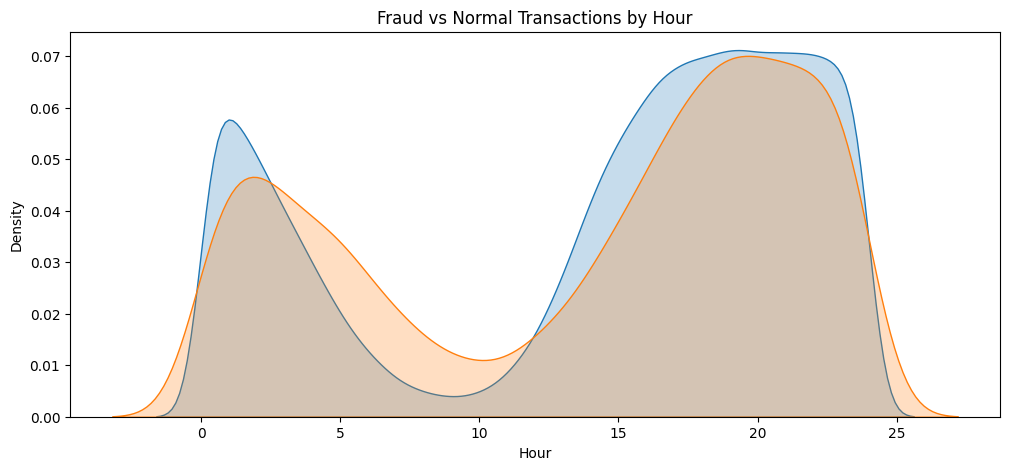

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.kdeplot(train[train['isFraud'] == 0]['Hour'], label='Normal', shade=True)
sns.kdeplot(train[train['isFraud'] == 1]['Hour'], label='Fraud', shade=True)
plt.title('Fraud vs Normal Transactions by Hour')
plt.show()

(0.0, 1000.0)

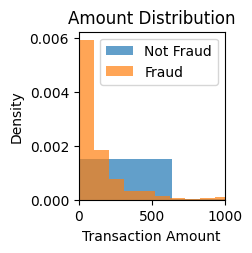

In [31]:

# Plot 1: Amount distribution
plt.subplot(2, 3, 1)
plt.hist(train[train['isFraud']==0]['TransactionAmt'], bins=50, alpha=0.7, label='Not Fraud', density=True)
plt.hist(train[train['isFraud']==1]['TransactionAmt'], bins=50, alpha=0.7, label='Fraud', density=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.title('Amount Distribution')
plt.legend()
plt.xlim(0, 1000)  # Limit for better visibility

Text(0.5, 1.0, 'Log Transaction Amount by Transaction Type')

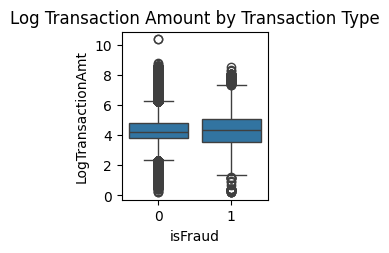

In [32]:
# Plot 2: Log amounts
plt.subplot(2, 3, 2)
train['LogTransactionAmt'] = np.log1p(train['TransactionAmt'])
sns.boxplot(x='isFraud', y='LogTransactionAmt', data=train)
plt.title('Log Transaction Amount by Transaction Type')

ProductCD
C    0.116873
S    0.058996
H    0.047662
R    0.037826
W    0.020399
Name: isFraud, dtype: float64


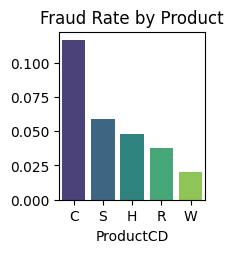

In [33]:
# 8.3: ProductCD (Product Type)
plt.subplot(2, 3, 3)
product_fraud = train.groupby('ProductCD')['isFraud'].mean().sort_values(ascending=False)
sns.barplot(x=product_fraud.index, y=product_fraud.values, palette='viridis')
plt.title('Fraud Rate by Product')
print(product_fraud)


([0, 1, 2, 3],
 [Text(0, 0, 'visa'),
  Text(1, 0, 'mastercard'),
  Text(2, 0, 'american express'),
  Text(3, 0, 'discover')])

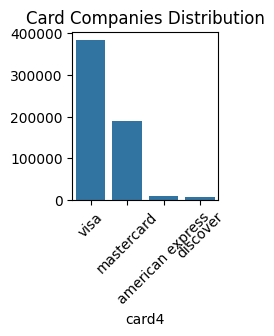

In [34]:
# 8.4: card4 (Card Company)
plt.subplot(2, 3, 4)
card4_counts = train['card4'].value_counts().head(5)
sns.barplot(x=card4_counts.index, y=card4_counts.values)
plt.title('Card Companies Distribution')
plt.xticks(rotation=45)

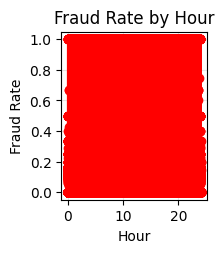

In [35]:
# 8.5: Fraud by Hour
plt.subplot(2, 3, 5)
fraud_by_hour = train.groupby('Hour')['isFraud'].mean()
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o', color='red')
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.grid(True, alpha=0.3)

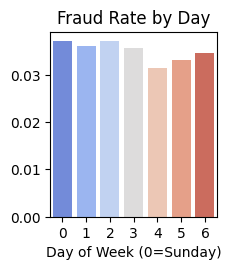

In [36]:
# 8.6: Fraud by Day of Week
plt.subplot(2, 3, 6)
fraud_by_day = train.groupby('DayOfWeek')['isFraud'].mean()
sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, palette='coolwarm')
plt.title('Fraud Rate by Day')
plt.xlabel('Day of Week (0=Sunday)')

plt.tight_layout()
plt.show()

# Data Cleaning

**Cleaning by Removal**

In [37]:
# تحويل أي قيمة Infinity إلى NaN في الجدولين
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [38]:
train_null_pct = train.isnull().sum() / len(train)
test_null_pct = test.isnull().sum() / len(test)

In [39]:
#colums has > 90% missing 
null_90_cols = [col for col in train.columns if train_null_pct[col] > 0.90 or (col in test.columns and test_null_pct[col] > 0.90)]


In [40]:
train.drop(columns=null_90_cols, inplace=True)
test.drop(columns=null_90_cols, inplace=True)

In [41]:
print(f"remove {len(null_90_cols)} colums has missed >90")
print(f" existed columns: {train.shape[1]}")

remove 12 colums has missed >90
 existed columns: 425


In [42]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]

In [43]:
train.drop(columns=one_value_cols, inplace=True)
test.drop(columns=one_value_cols, inplace=True)

In [44]:

print(f"Final shape of training data: {train.shape}")

Final shape of training data: (590540, 425)


In [45]:
# 9.3: Memory Optimization
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"   Memory usage before: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"   Memory usage after: {end_mem:.2f} MB")
    print(f"   Reduction: {100 * (start_mem - end_mem) / start_mem:.1f}%")
    return df

train = reduce_memory(train)
test = reduce_memory(test)

print(f"\n Final dimensions after cleaning:")
print(f"   Training: {train.shape}")
print(f"   Test: {test.shape}")

   Memory usage before: 1062.73 MB
   Memory usage after: 627.39 MB
   Reduction: 41.0%
   Memory usage before: 1623.61 MB
   Memory usage after: 542.17 MB
   Reduction: 66.6%

 Final dimensions after cleaning:
   Training: (590540, 425)
   Test: (506691, 420)


In [46]:
remaining_missing_cols = train.isnull().any().sum()
max_missing_pct = (train.isnull().sum() / len(train) * 100).max()

In [47]:
print(f"missing values: {remaining_missing_cols}")
print(f"the highest missed values: {max_missing_pct:.2f}%")

missing values: 402
the highest missed values: 89.51%


# Categorical Encoding

In [48]:
from sklearn.preprocessing import LabelEncoder

In [49]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

In [50]:
# 2. Perform Label Encoding
for col in cat_cols:
    le = LabelEncoder()  
    # Fit the encoder on the combined data from train and test to handle all possible labels
    # We convert to string to ensure consistency and handle potential NaN issues
    full_data = pd.concat([train[col], test[col]]).astype(str)
    le.fit(full_data)
    
    # Transform both training and testing datasets
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
print(train.head())

   isFraud  TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  addr2  dist1  P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  D13  D14    D15  M1  M2  M3  M4  M5  M6  M7  ...  V324  V325  V326  V327  V328  V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339  id_01    id_02  id_03  id_04  id_05  id_06  id_09  id_10  id_11  id_12  id_13  id_14  id_15  id_16  id_17  id_19  id_20  id_28  id_29  id_30  id_31  id_32  id_33  id_34  id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  TransactionDay  DayOfWeek      Hour  LogTransactionAmt
0        0          86400            68.5          4  13926    NaN  150.0      1  142.0      1  315.0   87.0   19.0             32             32  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0   1

In [51]:
#just to detection 
initial_cat_cols_count = len(cat_cols)
remaining_cat_cols_count = len(train.select_dtypes(include=['object']).columns)
if initial_cat_cols_count > 0:
    success_rate = ((initial_cat_cols_count - remaining_cat_cols_count) / initial_cat_cols_count) * 100
else:
    success_rate = 100 

In [52]:
print(f"Total Categorical Columns identified: {initial_cat_cols_count}")
print(f"Categorical Columns remaining: {remaining_cat_cols_count}")
print(f"Encoding Success Rate: {success_rate:.2f}%")

Total Categorical Columns identified: 29
Categorical Columns remaining: 0
Encoding Success Rate: 100.00%


# Feature Engineering & Preprocessing

**Aggregations**

In [53]:
# 1. Create new features based on card1 behavior

train['Trans_Amt_Mean_Card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
test['Trans_Amt_Mean_Card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')

In [54]:
# Calculating the ratio of the transaction amount to the mean/std of that specific card
train['Trans_Amt_Std_Card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
test['Trans_Amt_Std_Card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')

**Aligning Train & Test**

In [55]:
# 2. Aligning columns between Train and Test (Keeping 'isFraud' in Train)
target = train['isFraud']
train_cols = [col for col in train.columns if col in test.columns]

train = train[train_cols]
test = test[train_cols]

In [56]:
# Bring back the target to training set
train['isFraud'] = target

print(f" Columns Aligned. Train: {train.shape}, Test: {test.shape}")

 Columns Aligned. Train: (590540, 423), Test: (506691, 422)


**Final Imputation**

In [57]:
# 1. Fill Numerical columns with Median (Handling all numeric subtypes like float16, int32, etc.)
# We select all columns EXCEPT the ones that might be objects
numeric_all = train.select_dtypes(include=[np.number]).columns

In [58]:
# Fill Train and Test
train[numeric_all] = train[numeric_all].fillna(train[numeric_all].median())
test[numeric_all] = test[numeric_all].fillna(test[numeric_all].median())


KeyError: "['isFraud'] not in index"

In [59]:
train = train.fillna(0)
test = test.fillna(0)

In [60]:
# Final validation check
remaining_nan = train.isnull().sum().sum()
print(f"Total NaN values remaining in Train: {remaining_nan}")

Total NaN values remaining in Train: 0


# Balance Data using SMOTE

In [ ]:
# # For balancing data
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTEENN

In [ ]:

# # Load identity data for more analysis
# train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
# train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [ ]:
# # 1. By Product Code

# product_fraud = train.groupby('ProductCD')['isFraud'].agg(['count', 'sum', 'mean'])
# product_fraud.columns = ['Total', 'Fraud_Count', 'Fraud_Rate']
# product_fraud = product_fraud.sort_values('Fraud_Rate', ascending=False)
# print(product_fraud)

In [ ]:
# # 2. By Card Type
# print("\n2️⃣ By Card Type (card4):")
# card_fraud = train.groupby('card4')['isFraud'].agg(['count', 'sum', 'mean'])
# card_fraud.columns = ['Total', 'Fraud_Count', 'Fraud_Rate']
# card_fraud = card_fraud.sort_values('Fraud_Rate', ascending=False)
# print(card_fraud)

In [ ]:
# # 3. By Device Type
# print("\n3️⃣ By Device Type:")
# if 'DeviceType' in train.columns:
#     device_fraud = train.groupby('DeviceType')['isFraud'].agg(['count', 'sum', 'mean'])
#     device_fraud.columns = ['Total', 'Fraud_Count', 'Fraud_Rate']
#     print(device_fraud)

In [ ]:
# # Check current distribution
# print(f"\nBefore balancing:")
# print(f"   Legitimate: {(y_clean==0).sum():,}")
# print(f"   Fraud: {(y_clean==1).sum():,}")
# print(f"   Ratio: 1:{(y_clean==0).sum()/(y_clean==1).sum():.1f}")


In [ ]:
# # Method 1: SMOTE (Synthetic Minority Over-sampling)
# print("\n Applying SMOTE...")
# smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Make fraud 50% of legitimate
# X_resampled, y_resampled = smote.fit_resample(X_clean, y_clean)

# print(f"\n After SMOTE:")
# print(f"   Total samples: {len(y_resampled):,}")
# print(f"   Legitimate: {(y_resampled==0).sum():,}")
# print(f"   Fraud: {(y_resampled==1).sum():,}")
# print(f"   Ratio: 1:{(y_resampled==0).sum()/(y_resampled==1).sum():.1f}")

In [ ]:
 # adasyn = ADASYN(random_state=42, sampling_strategy=0.5)
 # X_resampled, y_resampled = adasyn.fit_resample(X_clean, y_clean)

In [ ]:
# smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.5)
# X_resampled, y_resampled = smote_enn.fit_resample(X_clean, y_clean)

In [ ]:
# # Visualization

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Before balancing
# axes[0].bar(['Legitimate', 'Fraud'], [(y_clean==0).sum(), (y_clean==1).sum()], 
#             color=['skyblue', 'salmon'], alpha=0.8)
# axes[0].set_title('Before Balancing', fontsize=14, fontweight='bold')
# axes[0].set_ylabel('Count')
# for i, v in enumerate([(y_clean==0).sum(), (y_clean==1).sum()]):
#     axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')


In [ ]:
# # After balancing
# axes[1].bar(['Legitimate', 'Fraud'], [(y_resampled==0).sum(), (y_resampled==1).sum()], 
#             color=['lightgreen', 'orange'], alpha=0.8)
# axes[1].set_title('After SMOTE Balancing', fontsize=14, fontweight='bold')
# axes[1].set_ylabel('Count')
# for i, v in enumerate([(y_resampled==0).sum(), (y_resampled==1).sum()]):
#     axes[1].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# plt.tight_layout()
# plt.show()